In [1]:
%matplotlib inline


# Getting started tutorial

In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting
algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


In [119]:
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd

In [3]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [4]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [5]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [6]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [7]:
import spikeinterface.full as si

In [8]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

## Part 1: Importing Data

### Path for all data and processed files

`/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/`

- Looking over the metadata file

In [9]:
with open("/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/data/recording/02122021_BLA4-1_1v2_Competition_Day1.info.dat") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

<Start settings>

Description: Channel info for PHY data

Byte_order: little endian

Original_file: 02122021_BLA4-1_1v2_Competition_Day1.rec

Clock rate: 20000

Decimation: 1

Number_of_channels: 32

Fields: <nTrode int16><nTrodeChannel int16>

<End settings>

                       	   

         

                                                             


- Reading in the data into Spikeinterface

In [10]:
recording = se.read_spikegadgets("/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/data/recording/02122021_BLA4-1_1v2_Competition_Day1.rec")

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


In [11]:
type(recording)

spikeinterface.extractors.neoextractors.spikegadgets.SpikeGadgetsRecordingExtractor

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc. Since the data are simulated, :code:`sorting_true` has ground-truth information of the spiking
activity of each unit.

Let's use the :code:`widgets` module to visualize the traces and the raster plots.



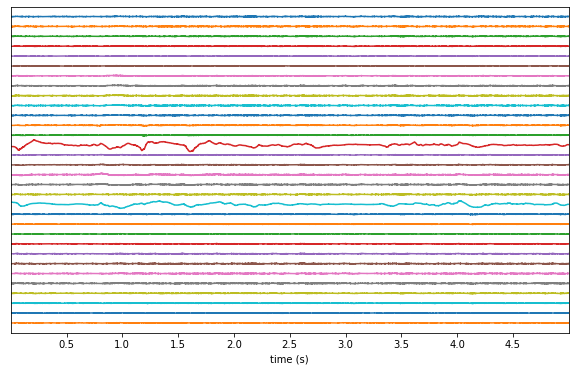

In [12]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))


This is how you retrieve info from a :code:`RecordingExtractor`...



In [13]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
duration = recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 66378757
Number of hours: 0.9219271805555554


...and a :code:`SortingExtractor`



In [14]:
num_seg = recording.get_num_segments()

print('Number of segments:', num_seg)

Number of segments: 1


:code:`spikeinterface` internally uses the :code:`probeinterface`
to handle Probe and ProbeGroup.
 So any probe in the probeinterface collections can be download
and set to a Recording object.
In this case, the MEArec dataset already handles a Probe and we don't need to set it.



Using the :code:`toolkit`, you can perform preprocessing on the recordings.
Each pre-processing function also returns a :code:`RecordingExtractor`,
which makes it easy to build pipelines. Here, we filter the recording and
apply common median reference (CMR).
All theses preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.



# Setting Probes

In [15]:
# importing the module
import json

In [16]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe

## Opening up relevant Probe Metadata

In [17]:
with open("/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/data/probe/nancyparameters.prm") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

experiment_name = '02122021_BLA4-1_1v2_Competition_Day1.phy'

prb_file = 'nancyprobe_linearprobelargespace.prb'  # or the path to your PRB file



traces = dict(

    raw_data_files=[experiment_name + '.dat'],  # path to your .dat file(s)

    sample_rate=20000,  # sampling rate in Hz

    n_channels=32,  # number of channels in the .dat files

    dtype='int16',  # the data type used in the .dat files

)



# Parameters for the spike detection process.

spikedetekt = dict(



    filter_high_factor=0.95 * .5,

    filter_butter_order=3,  # Order of Butterworth filter.





    chunk_size_seconds=1,

    chunk_overlap_seconds=.015,



    n_excerpts=50,

    excerpt_size_seconds=1,

    threshold_strong_std_factor=3.5,

    threshold_weak_std_factor=3,

    detect_spikes='positive',

    use_single_threshold=True,

    connected_component_join_size=1,



    extract_s_before=10,

    extract_s_after=15,



    n_features_per_channel=3,  # Number of features per channel.

    pca_n_wave

In [18]:
with open("/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/data/probe/nancyprobe_linearprobelargespace.prb") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

- TODO: Create a probe group: https://probeinterface.readthedocs.io/_/downloads/en/latest/pdf/

## Making a probe from scratch

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from probeinterface import Probe, ProbeGroup
from probeinterface import Probe
from probeinterface.plotting import plot_probe_group
from probeinterface.plotting import plot_probe

In [20]:
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface.generator import generate_tetrode
from probeinterface.generator import generate_linear_probe
from probeinterface.generator import generate_multi_columns_probe

- Making 8 tetrodes for 32 channels

In [21]:
import itertools

In [22]:
probegroup = ProbeGroup()
x_difference = [0, 40, 80, 120]
y_difference = [0, 40]
difference_combinations = list(itertools.product(x_difference, y_difference))

for num in range(8):   
    current_tetrode = generate_tetrode()
    current_tetrode.move([difference_combinations[num][0], difference_combinations[num][1]])
    probegroup.add_probe(current_tetrode)

probegroup.set_global_device_channel_indices(np.arange(32))

In [23]:
probegroup.get_channel_count()

32

In [24]:
probegroup.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (1,  4), (1,  5), (1,  6),
       (1,  7), (2,  8), (2,  9), (2, 10), (2, 11), (3, 12), (3, 13),
       (3, 14), (3, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 20),
       (5, 21), (5, 22), (5, 23), (6, 24), (6, 25), (6, 26), (6, 27),
       (7, 28), (7, 29), (7, 30), (7, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

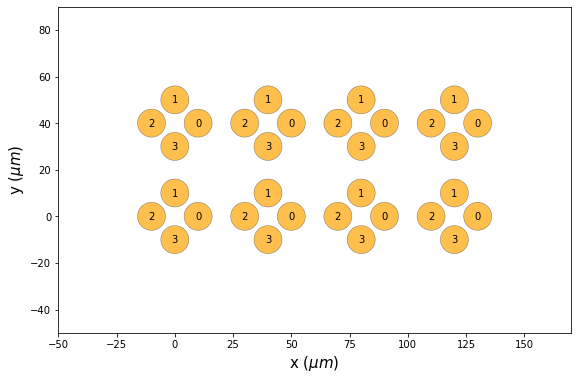

In [25]:
plot_probe_group(probegroup, same_axes=True, with_channel_index=True)

In [26]:
probegroup.to_dataframe()

probe_index             x             y contact_shapes  radius shank_ids  \
0             0  1.000000e+01  0.000000e+00         circle     6.0             
1             0  6.123234e-16  1.000000e+01         circle     6.0             
2             0 -1.000000e+01  1.224647e-15         circle     6.0             
3             0 -1.836970e-15 -1.000000e+01         circle     6.0             
4             1  1.000000e+01  4.000000e+01         circle     6.0             
5             1  6.123234e-16  5.000000e+01         circle     6.0             
6             1 -1.000000e+01  4.000000e+01         circle     6.0             
7             1 -1.836970e-15  3.000000e+01         circle     6.0             
8             2  5.000000e+01  0.000000e+00         circle     6.0             
9             2  4.000000e+01  1.000000e+01         circle     6.0             
10            2  3.000000e+01  1.224647e-15         circle     6.0             
11            2  4.000000e+01 -1.000000e+01         circle     6.0             
12            3  5.000000e+01  4.000000e+01         circle     6.0             
13            3  4.000000e+01  5.000000e+01         circle     6.0             
14            3  3.000000e+01  4.000000e+01         circle     6.0             
15            3  4.000000e+01  3.000000e+01         circle     6.0             
16            4  9.000000e+01  0.000000e+00         circle     6.0             
17            4  8.000000e+01  1.000000e+01         circle     6.0             
18            4  7.000000e+01  1.224647e-15         circle     6.0             
19            4  8.000000e+01 -1.000000e+01         circle     6.0             
20            5  9.000000e+01  4.000000e+01         circle     6.0             
21            5  8.000000e+01  5.000000e+01         circle     6.0             
22            5  7.000000e+01  4.000000e+01         circle     6.0             
23            5  8.000000e+01  3.000000e+01         circle     6.0             
24            6  1.300000e+02  0.000000e+00         circle     6.0             
25            6  1.200000e+02  1.000000e+01         circle     6.0             
26            6  1.100000e+02  1.224647e-15         circle     6.0             
27            6  1.200000e+02 -1.000000e+01         circle     6.0             
28            7  1.300000e+02  4.000000e+01         circle     6.0             
29            7  1.200000e+02  5.000000e+01         circle     6.0             
30            7  1.100000e+02  4.000000e+01         circle     6.0             
31            7  1.200000e+02  3.000000e+01         circle     6.0             

   contact_ids  
0               
1               
2               
3               
4               
5               
6               
7               
8               
9               
10              
11              
12              
13              
14              
15              
16              
17              
18              
19              
20              
21              
22              
23              
24              
25              
26              
27              
28              
29              
30              
31

### Multishank Probe

In [27]:
multi_shank = generate_multi_shank(num_shank=32, num_columns=1, num_contact_per_column=1)

(<matplotlib.collections.PolyCollection at 0x7f3f75f1ea10>,
 <matplotlib.collections.PolyCollection at 0x7f3f75feb290>)

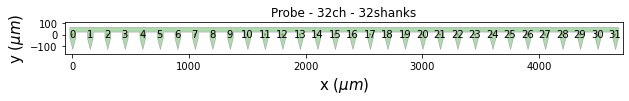

In [28]:
plot_probe(multi_shank, with_channel_index=True)

In [29]:
multi_shank.set_device_channel_indices(np.arange(32))

In [30]:
recording = recording.set_probes(multi_shank)

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


## Preprocessing

- With Maya's preprocessing method

In [31]:
# Bandpass Filtering
recording_f = st.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


In [32]:
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_f)
print(recording_rm_noise)

RemoveBadChannelsRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


In [33]:
# Re-referencing
recording_cmr = st.common_reference(recording_rm_noise, reference='global', operator='median')
print(recording_cmr)


CommonReferenceRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


## Visualization and EDA

(11.0, 16.0, -2636.25, 84360.0)

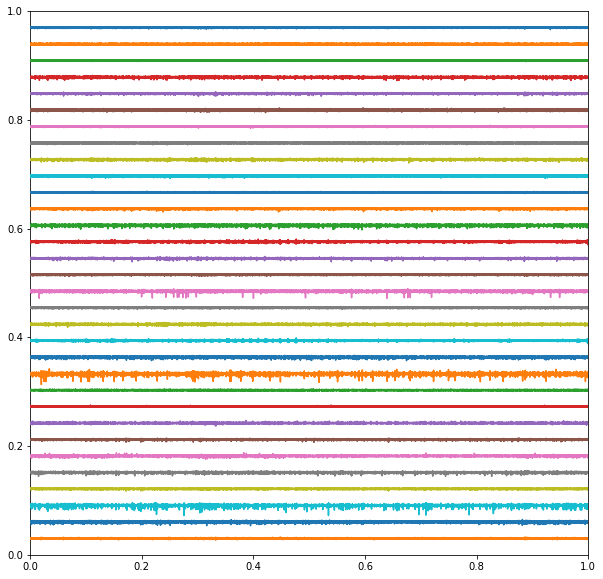

In [34]:
plt_kwargs = {'linewidth': 0.05}
fig, ax = plt.subplots(1,1, figsize=(10,10), **plt_kwargs)
sw.plot_timeseries(recording_cmr, time_range=[11,16], figure=fig)
plt.axis('off')

(11.0, 16.0, -854.25, 3417.0)

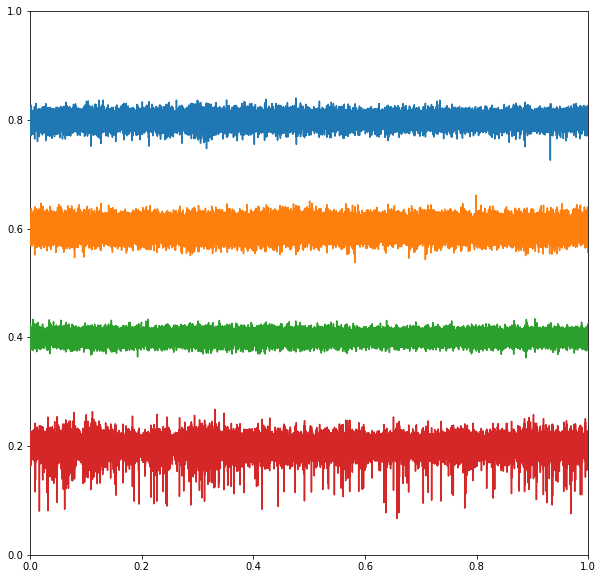

In [35]:
plt_kwargs = {'linewidth': 0.05}
fig, ax = plt.subplots(1,1, figsize=(10,10), **plt_kwargs)
sw.plot_timeseries(recording_cmr, time_range=[11,16], figure=fig,
                  channel_ids=['0', '1', '2', '3'])
plt.axis('off')

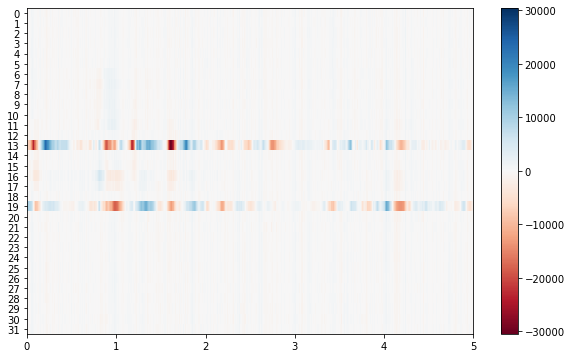

In [36]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5), mode="map", show_channel_ids=True,)


`ValueError: There is not Probe attached to recording. use set_probe(...)`

## Sorting

Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [37]:
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'tridesclous', 'waveclus', 'yass']


/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEAutility/core.py:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(yaml.__version__) >= StrictVersion('5.0.0'):
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/tools.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(yaml.__version__) >= StrictVersion('5.0.0'):
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/simulate_cells.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(yaml.__version__) >= StrictVersion('5.0.0'):
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/MEArec/genera

Installed sorters ['herdingspikes', 'mountainsort4', 'tridesclous']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



In [38]:
print(ss.get_default_params('mountainsort4'))

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}


Let's run mountainsort4 and change one of the parameter, say, the detect_threshold:



In [39]:
ms4_params = ss.get_default_params('mountainsort4').copy()

In [40]:
ms4_params['adjacency_radius'] = 100
ms4_params['detect_sign'] = 0
ms4_params['filter'] = False
ms4_params['num_workers'] = 8
ms4_params['detect_interval'] = 30

In [41]:
sorting_ms4 = ss.read_sorter_folder("./proc/mountainsort4_output")

- TODO's
    - Look into what the parameters do(like freq_min)
    - Compare it with the original recording 
    - Plotting PC space and ISI(interspike interval interval)
    - Average wave form of each 
    - Look over Maya's video and follow her visualization

## Extracting Waveforms

In [42]:
from spikeinterface import WaveformExtractor, extract_waveforms
import spikeinterface.extractors as se

- For Mountainsort

In [43]:
raise ValueError("Stop!")

ValueError: Stop!

In [44]:
we_mountainsort = si.extract_waveforms(recording=recording_cmr, 
                                       sorting=sorting_ms4, folder='`/nancy/user/riwata/projects/spike_sorting/results/2022_06_01_visualization/proc/ms4_waveforms',
                                      ms_before=1, ms_after=1, progress_bar=True,
                                      n_jobs=8, total_memory="1G", overwrite=True,
                                       max_spikes_per_unit=2000)

extract waveforms:   0%|                                                                                                                               | 0/34 [00:00<?, ?it/s]

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


extract waveforms: 100%|######################################################################################################################| 34/34 [01:33<00:00,  2.75s/it]


In [46]:
we_mountainsort

WaveformExtractor: 32 channels - 46 units - 1 segments
  before:20 after20 n_per_units: 2000

### Filtering by Signal to Noise Ratio

In [47]:
mask = np.array(list(st.compute_snrs(we_mountainsort).values())) > 4

In [48]:
mask = np.array(list(st.compute_snrs(we_mountainsort).values())) > 8

In [49]:
sorting_ms4.get_unit_ids()[mask]

array([ 5, 20, 23, 26, 41, 42, 43, 44])

In [50]:
len(sorting_ms4.get_unit_ids()[mask])

8

## Plotting the Waveforms for a single unit

- Each column represents a single channel
    - We are plotting the units with the highest signal to noise ratio

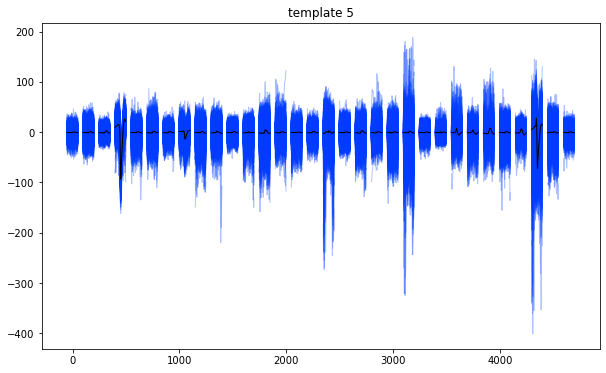

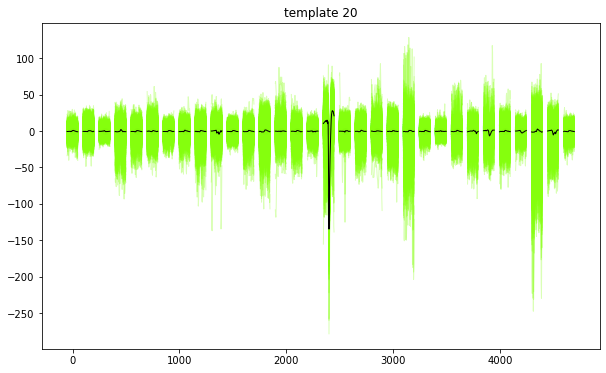

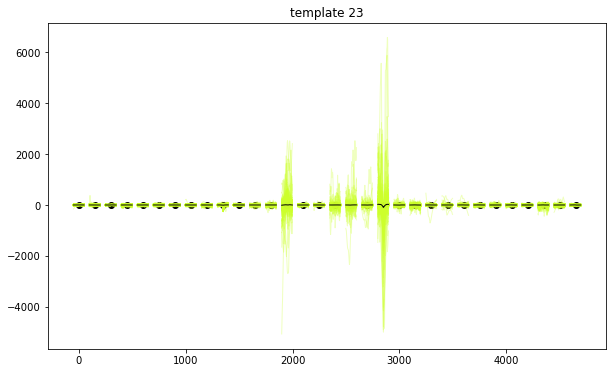

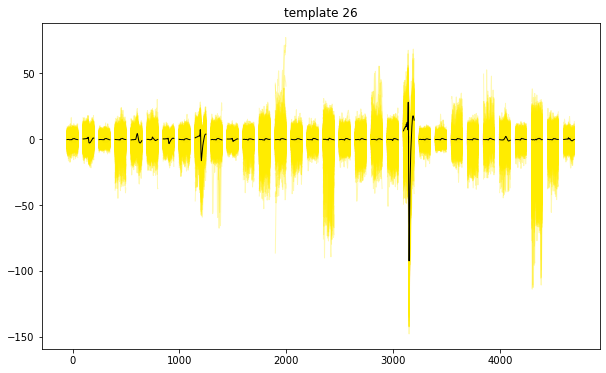

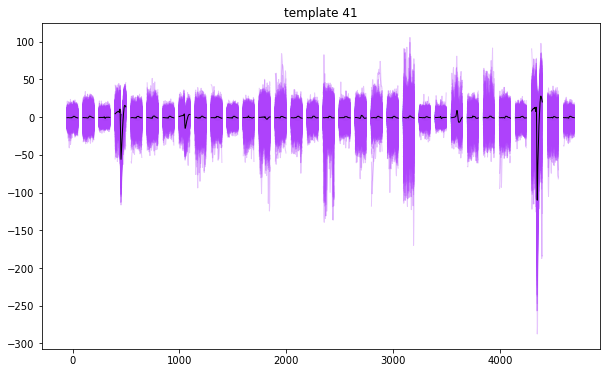

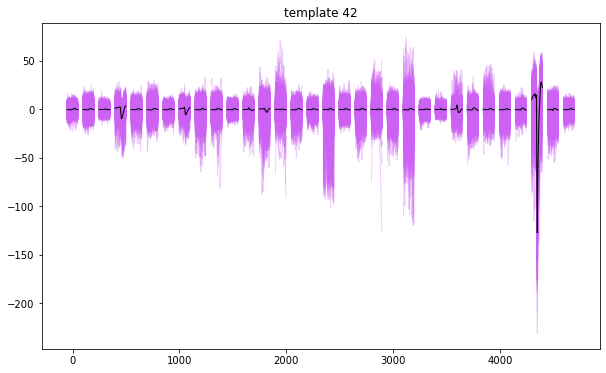

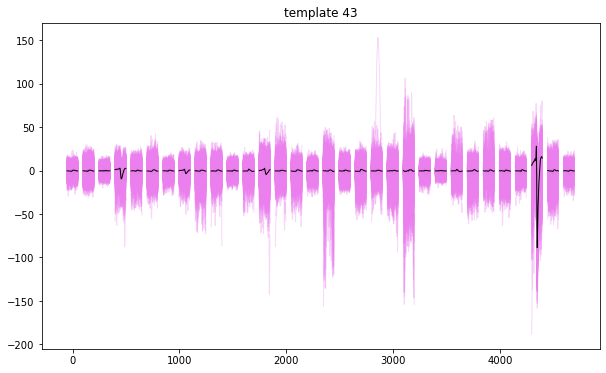

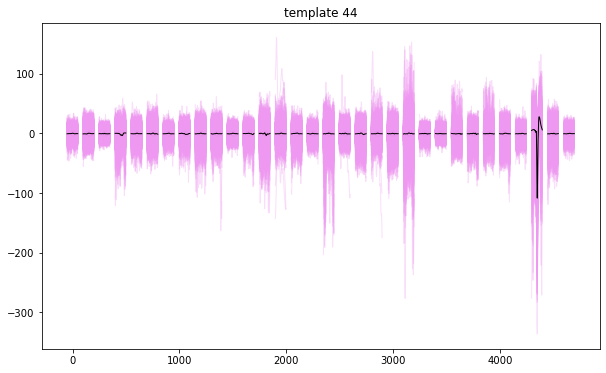

In [51]:
for num in sorting_ms4.get_unit_ids()[mask]:
    sw.plot_unit_waveforms(we_mountainsort, unit_ids=[num], plot_templates=True, plot_channels=True)

## Plotting the Waveforms for a single channel

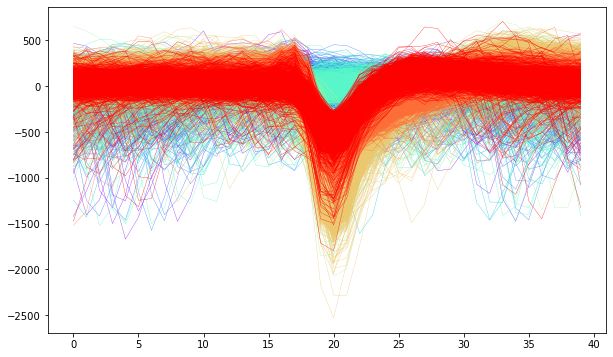

In [52]:
n = 8
colors = iter(cm.rainbow(np.linspace(0, 1, n)))

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.get_unit_ids()[mask][:n]):
    wf = we_mountainsort.get_waveforms(unit_id)
    color = next(colors)
    ax.plot(wf[:, :, 29].T, color=color, lw=0.3)

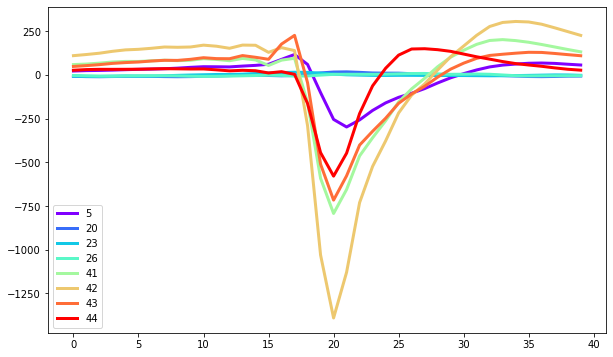

In [53]:
n = 8
colors = iter(cm.rainbow(np.linspace(0, 1, n)))

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.get_unit_ids()[mask][:n]):
    template = we_mountainsort.get_template(unit_id)
    color = next(colors)
    ax.plot(template[:, 29].T, color=color, lw=3, label=unit_id)
ax.legend()

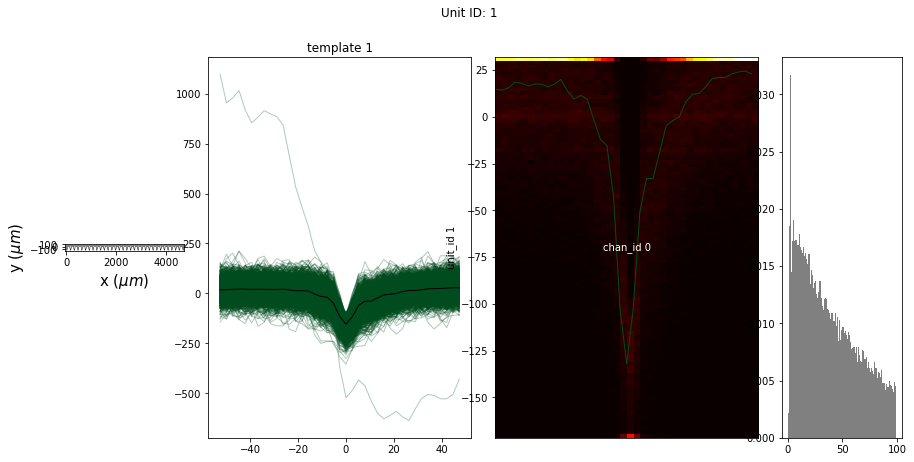

In [54]:
w = sw.plot_unit_summary(we_mountainsort, unit_id=1)

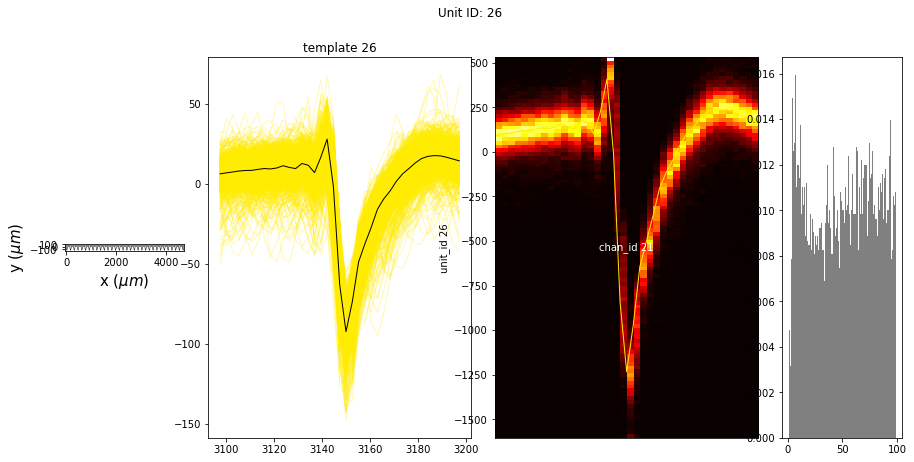

In [55]:
w = sw.plot_unit_summary(we_mountainsort, unit_id=26)

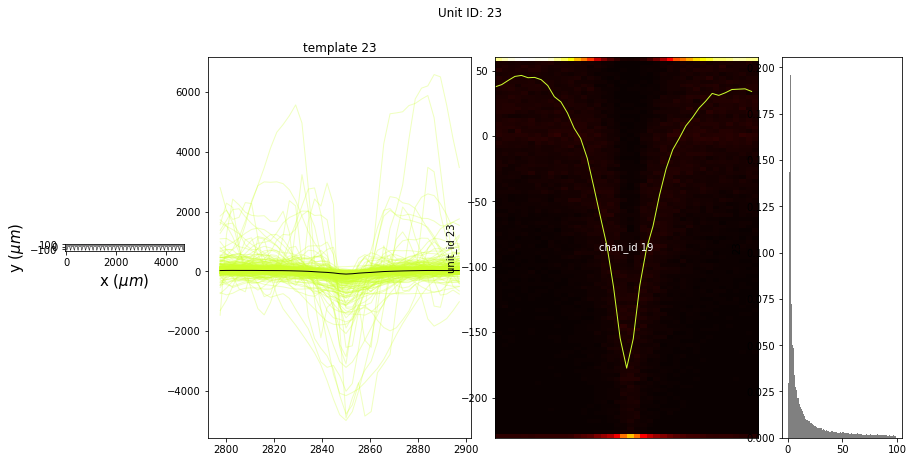

In [56]:
w = sw.plot_unit_summary(we_mountainsort, unit_id=23)

Once we have the  `WaveformExtractor` object
we can post-process, validate, and curate the results. With
the :code:`toolkit.postprocessing` submodule, one can, for example,
get waveforms, templates, maximum channels, PCA scores, or export the data
to Phy. `Phy <https://github.com/cortex-lab/phy>`_ is a GUI for manual
curation of the spike sorting output. To export to phy you can run:



In [57]:
we_TDC = si.WaveformExtractor.create(recording_cmr, sorting_ms4, 'waveforms', remove_if_exists=True)
we_TDC.set_params(ms_before=3., ms_after=4., max_spikes_per_unit=500)
we_TDC.run_extract_waveforms(n_jobs=-1, chunk_size=30000)
print(we_TDC)

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']
WaveformExtractor: 32 channels - 46 units - 1 segments
  before:60 after80 n_per_units: 500


In [58]:
from spikeinterface.exporters import export_to_phy

export_to_phy(we_TDC, './phy_folder_for_TDC',
              compute_pc_features=False, compute_amplitudes=True)

write_binary_recording with n_jobs 1  chunk_size None
This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


KeyboardInterrupt: 

Then you can run the template-gui with: :code:`phy template-gui phy/params.py`
and manually curate the results.



Quality metrics for the spike sorting output are very important to asses the spike sorting performance.
The :code:`spikeinterface.toolkit.qualitymetrics` module implements several quality metrics
to assess the goodness of sorted units. Among those, for example,
are signal-to-noise ratio, ISI violation ratio, isolation distance, and many more.
Theses metrics are built on top of WaveformExtractor class and return a dictionary with the unit ids as keys:



In [ ]:
st.compute_isi_violations(we_TDC, isi_threshold_ms=1.5)

In [ ]:
snrs = st.compute_snrs(we_TDC)
print(snrs)
isi_violations_rate, isi_violations_count = st.compute_isi_violations(we_TDC, isi_threshold_ms=1.5)
print(isi_violations_rate)
print(isi_violations_count)

All theses quality metrics can be computed in one shot and returned as
a :code:`pandas.Dataframe`



In [ ]:
metrics = st.compute_quality_metrics(we_TDC, metric_names=['snr', 'isi_violation', 'amplitude_cutoff'])
print(metrics)

Quality metrics can be also used to automatically curate the spike sorting
output. For example, you can select sorted units with a SNR above a
certain threshold:



In [ ]:
keep_mask = (metrics['snr'] > 7.5) & (metrics['isi_violations_rate'] < 0.01)
print(keep_mask)

keep_unit_ids = keep_mask[keep_mask].index.values
print(keep_unit_ids)

curated_sorting = sorting_ms4.select_units(keep_unit_ids)
print(curated_sorting)

The final part of this tutorial deals with comparing spike sorting outputs.
We can either (1) compare the spike sorting results with the ground-truth
sorting :code:`sorting_true`, (2) compare the output of two (mountainsort4
and Tridesclous), or (3) compare the output of multiple sorters:



In [ ]:
comp_gt_TDC = sc.compare_sorter_to_ground_truth(gt_sorting=sorting_true, tested_sorting=sorting_TDC)
comp_TDC_HS = sc.compare_two_sorters(sorting1=sorting_TDC, sorting2=sorting_HS)
comp_multi = sc.compare_multiple_sorters(sorting_list=[sorting_TDC, sorting_HS],
                                         name_list=['tdc', 'hs'])

When comparing with a ground-truth sorting extractor (1), you can get the sorting performance and plot a confusion
matrix



In [ ]:
comp_gt_TDC.get_performance()
w_conf = sw.plot_confusion_matrix(comp_gt_TDC)
w_agr = sw.plot_agreement_matrix(comp_gt_TDC)

When comparing two sorters (2), we can see the matching of units between sorters.
Units which are not matched has -1 as unit id:



In [ ]:
comp_TDC_HS.hungarian_match_12

or the reverse:



In [ ]:
comp_TDC_HS.hungarian_match_21

When comparing multiple sorters (3), you can extract a :code:`SortingExtractor` object with units in agreement
between sorters. You can also plot a graph showing how the units are matched between the sorters.



In [ ]:
sorting_agreement = comp_multi.get_agreement_sorting(minimum_agreement_count=2)

print('Units in agreement between Klusta and Mountainsort4:', sorting_agreement.get_unit_ids())

w_multi = sw.plot_multicomp_graph(comp_multi)

plt.show()

# ISI Violations

- https://github.com/SpikeInterface/spikeinterface/blob/master/spikeinterface/toolkit/qualitymetrics/misc_metrics.py

- https://numpy.org/doc/stable/reference/generated/numpy.diff.html

## Compute unit maximum channel¶

- For each unit, calculating the channel with the highest the most extreme signal

In [89]:
extremum_channels_ids = st.get_template_extremum_channel(we_mountainsort, peak_sign='neg')
print(extremum_channels_ids)

{1: '0', 2: '1', 3: '2', 4: '3', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '21', 12: '9', 13: '10', 14: '11', 15: '12', 16: '13', 17: '14', 18: '15', 19: '16', 20: '16', 21: '17', 22: '18', 23: '19', 24: '20', 25: '21', 26: '21', 27: '22', 28: '23', 29: '24', 30: '24', 31: '24', 32: '25', 33: '26', 34: '26', 35: '26', 36: '27', 37: '28', 38: '25', 39: '28', 40: '28', 41: '29', 42: '29', 43: '29', 44: '29', 45: '30', 46: '31'}


In [90]:
extremum_channels_ids = st.get_template_extremum_channel(we_mountainsort, peak_sign='pos')
print(extremum_channels_ids)

{1: '0', 2: '1', 3: '13', 4: '3', 5: '29', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '21', 12: '9', 13: '10', 14: '11', 15: '12', 16: '13', 17: '14', 18: '15', 19: '16', 20: '16', 21: '17', 22: '18', 23: '19', 24: '20', 25: '21', 26: '21', 27: '22', 28: '13', 29: '24', 30: '24', 31: '24', 32: '25', 33: '26', 34: '26', 35: '26', 36: '27', 37: '28', 38: '25', 39: '26', 40: '26', 41: '29', 42: '29', 43: '29', 44: '29', 45: '30', 46: '13'}


In [120]:
channel_to_units = defaultdict(dict)
for k, v in extremum_channels_ids.items():
    channel_to_units[v] = channel_to_units.get(v, []) + [k]

In [121]:
channel_to_units

defaultdict(dict,
            {'0': [1],
             '1': [2],
             '13': [3, 16, 28, 46],
             '3': [4],
             '29': [5, 41, 42, 43, 44],
             '4': [6],
             '5': [7],
             '6': [8],
             '7': [9],
             '8': [10],
             '21': [11, 25, 26],
             '9': [12],
             '10': [13],
             '11': [14],
             '12': [15],
             '14': [17],
             '15': [18],
             '16': [19, 20],
             '17': [21],
             '18': [22],
             '19': [23],
             '20': [24],
             '22': [27],
             '24': [29, 30, 31],
             '25': [32, 38],
             '26': [33, 34, 35, 39, 40],
             '27': [36],
             '28': [37],
             '30': [45]})

In [123]:
channel_to_multiple_units = {k:v for k, v in channel_to_units.items() if len(v) >=2}

In [124]:
channel_to_multiple_units

{'13': [3, 16, 28, 46],
 '29': [5, 41, 42, 43, 44],
 '21': [11, 25, 26],
 '16': [19, 20],
 '24': [29, 30, 31],
 '25': [32, 38],
 '26': [33, 34, 35, 39, 40]}

# Quality Metrics

### Getting the Principal Components

In [61]:
pc = st.compute_principal_components(we_mountainsort, load_if_exists=True,
                                     n_components=3, mode='by_channel_local')


In [74]:
len(sorting_ms4.get_unit_ids())

46

(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(1130, 3, 32)
(316, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)


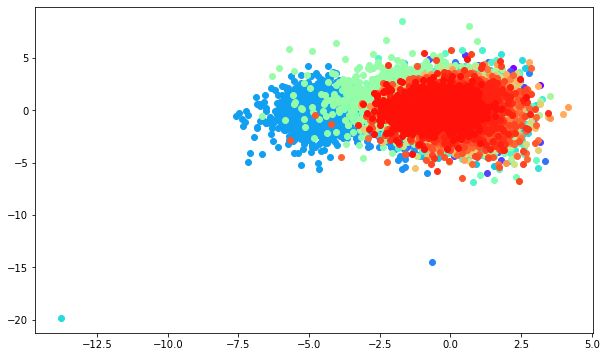

In [75]:
n = len(sorting_ms4.get_unit_ids()) + 1
colors = iter(cm.rainbow(np.linspace(0, 1, n)))

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.get_unit_ids()[:]):
    comp = pc.get_components(unit_id)
    print(comp.shape)
    color = next(colors)
    ax.scatter(comp[:, 0, 8], comp[:, 1, 8], color=color)

In [81]:
# with PCs
pca = st.WaveformPrincipalComponent(we_mountainsort)
pca.set_params(n_components=3, mode='by_channel_local')
pca.run()
metrics = st.compute_quality_metrics(we_mountainsort, waveform_principal_component=pca)
assert 'isolation_distance' in metrics.columns

In [84]:
metrics.to_parquet("./proc/mountainsort4_output/ms4_quality_metrics.parquet")

/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/fastparquet/util.py:20: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [87]:
ms4_quality_metrics_df = pd.read_parquet("./proc/mountainsort4_output/ms4_quality_metrics.parquet")

In [88]:
ms4_quality_metrics_df

num_spikes  firing_rate  presence_ratio        snr  \
index                                                       
1           43678    13.160234            1.00   4.048959   
2           26547     7.998643            1.00   3.656395   
3           36459    10.985141            1.00   3.607336   
4           47470    14.302769            1.00   5.092818   
5           19833     5.975707            1.00   8.867411   
6           76656    23.096546            1.00   5.162085   
7           56252    16.948796            1.00   4.249930   
8           69616    20.975385            1.00   4.503449   
9           53415    16.094004            1.00   4.891026   
10          78040    23.513547            1.00   4.886178   
11          11038     3.325763            1.00   7.840875   
12          32622     9.829048            1.00   4.452889   
13          32137     9.682917            1.00   3.480332   
14          84470    25.450913            1.00   6.245094   
15          89642    27.009243            1.00   5.400797   
16          74541    22.459294            1.00   7.318994   
17          97584    29.402178            1.00   6.355807   
18          72809    21.937440            1.00   4.381980   
19          35764    10.775737            1.00   5.152046   
20          49917    15.040053            1.00  13.122513   
21          37052    11.163813            1.00   3.893521   
22          94390    28.439821            1.00   5.529454   
23          92282    27.804679            1.00   8.446303   
24         139341    41.983612            1.00   5.125404   
25         128719    38.783191            1.00   7.347771   
26          11115     3.348963            1.00  18.520540   
27          44554    13.424174            1.00   4.244514   
28          31988     9.638023            1.00   3.523555   
29           4790     1.443233            1.00   4.873315   
30          53056    15.985837            1.00   5.301438   
31          18291     5.511100            1.00   5.754841   
32          90894    27.386472            1.00   6.476797   
33          11488     3.461348            1.00   4.035552   
34          51128    15.404928            1.00   7.308912   
35          13010     3.919929            1.00   5.777062   
36         117848    35.507745            1.00   4.951936   
37          31530     9.500027            1.00   3.767048   
38           1130     0.340470            0.95   7.630227   
39            316     0.095211            0.65   5.475673   
40           2120     0.638759            1.00   4.494193   
41          23920     7.207125            1.00  13.199423   
42          11891     3.582773            1.00  23.151766   
43          43514    13.110821            1.00  11.927753   
44          64367    19.393855            1.00   9.642790   
45         108303    32.631825            1.00   5.748360   
46          35575    10.718791            1.00   4.028058   

       isi_violations_rate  isi_violations_count  amplitude_cutoff  \
index                                                                
1                 0.059959                   199          0.000539   
2                 0.050317                   167          0.075982   
3                 0.080146                   266          0.000499   
4                 0.091897                   305          0.001167   
5                 0.002410                     8          0.000129   
6                 0.205789                   683          0.000129   
7                 0.117206                   389          0.000548   
8                 0.163607                   543          0.000129   
9                 0.125040                   415          0.003781   
10                0.230797                   766          0.006524   
11                0.001205                     4          0.006542   
12                0.047304                   157          0.000759   
13                0.065684                   218          0.000262   
14                0.323598  

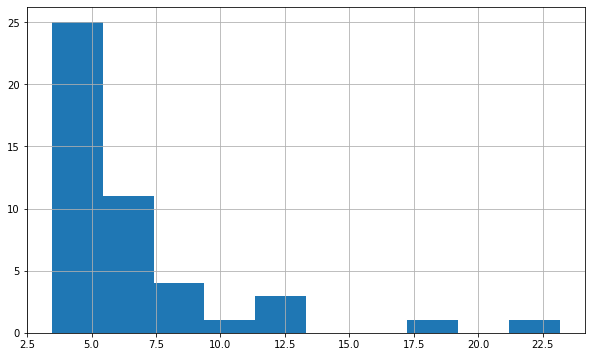

In [97]:
ms4_quality_metrics_df["snr"].hist()

- Focus on:
    snr, isi_violations_rate, isolation_distance

In [98]:
good_units = ms4_quality_metrics_df[(ms4_quality_metrics_df["snr"] >= 4) & (ms4_quality_metrics_df["isi_violations_rate"] < 0.01)]

In [116]:
good_units = ms4_quality_metrics_df[(ms4_quality_metrics_df["snr"] >= 4) & (ms4_quality_metrics_df["isi_violations_rate"] < 0.05) & (ms4_quality_metrics_df["isi_violations_rate"] > 0.01)]

In [117]:
good_units

num_spikes  firing_rate  presence_ratio        snr  \
index                                                       
12          32622     9.829048             1.0   4.452889   
19          35764    10.775737             1.0   5.152046   
41          23920     7.207125             1.0  13.199423   
43          43514    13.110821             1.0  11.927753   

       isi_violations_rate  isi_violations_count  amplitude_cutoff  \
index                                                                
12                0.047304                   157          0.000759   
19                0.041278                   137          0.000307   
41                0.018982                    63          0.004408   
43                0.041881                   139          0.001007   

       isolation_distance   l_ratio   d_prime  
index                                          
12              67.342327  8.931977  2.045852  
19              77.701013  5.531102  2.625967  
41              92.490887  2.225314  5.164467  
43              80.342619  5.871218  3.297171

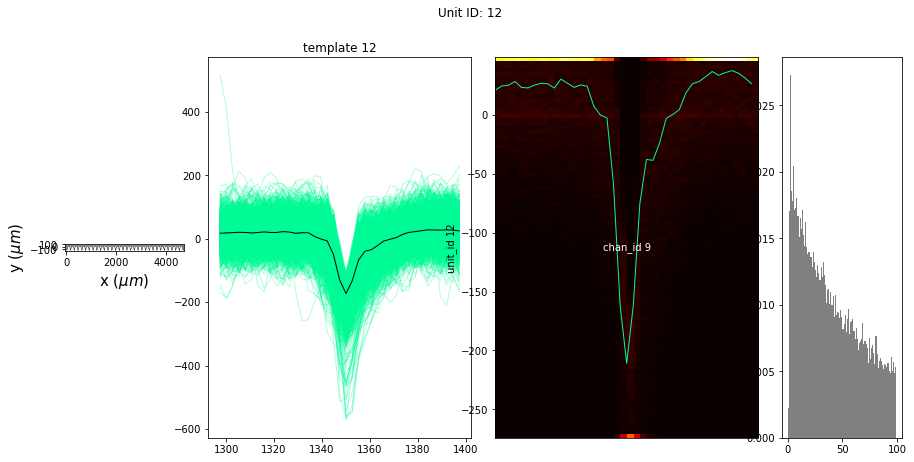

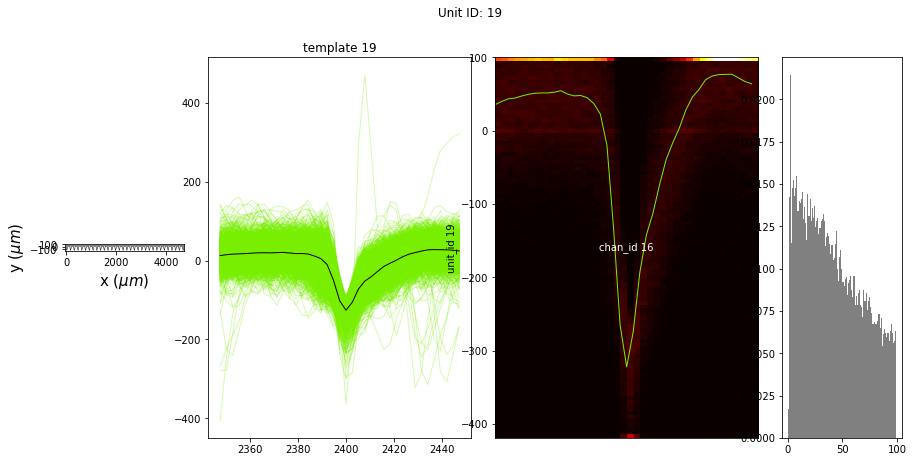

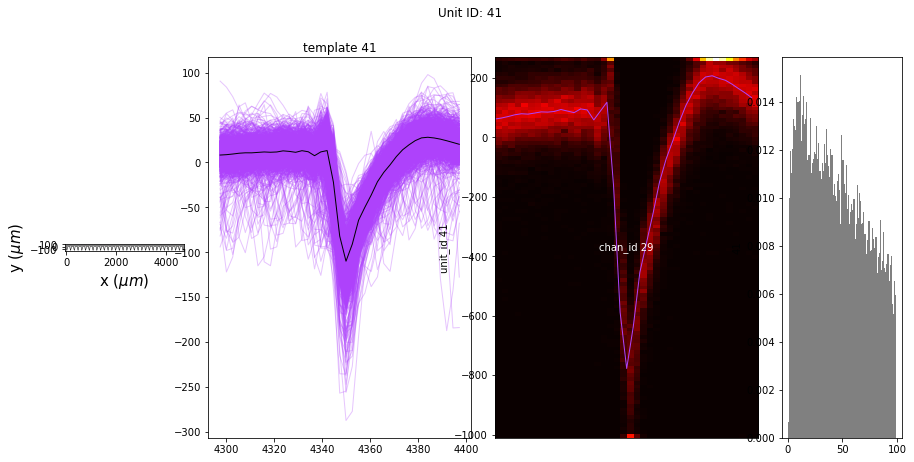

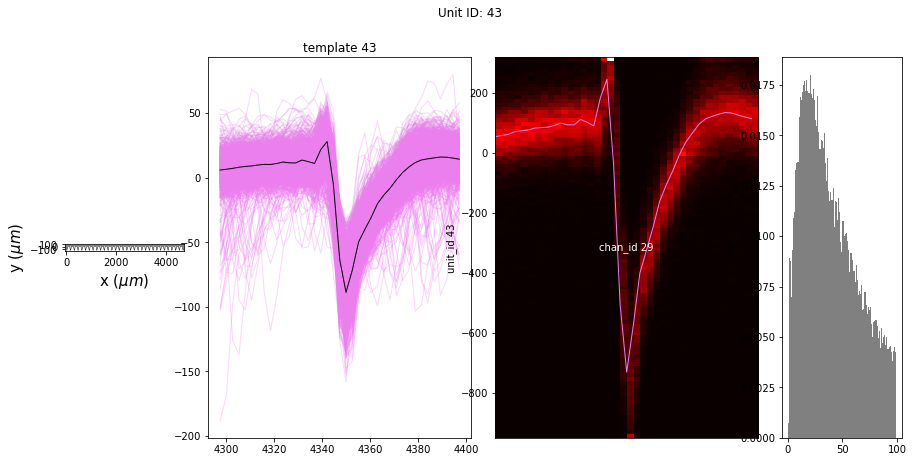

In [118]:
for index, unit in good_units.iterrows():
    w = sw.plot_unit_summary(we_mountainsort, unit_id=index)

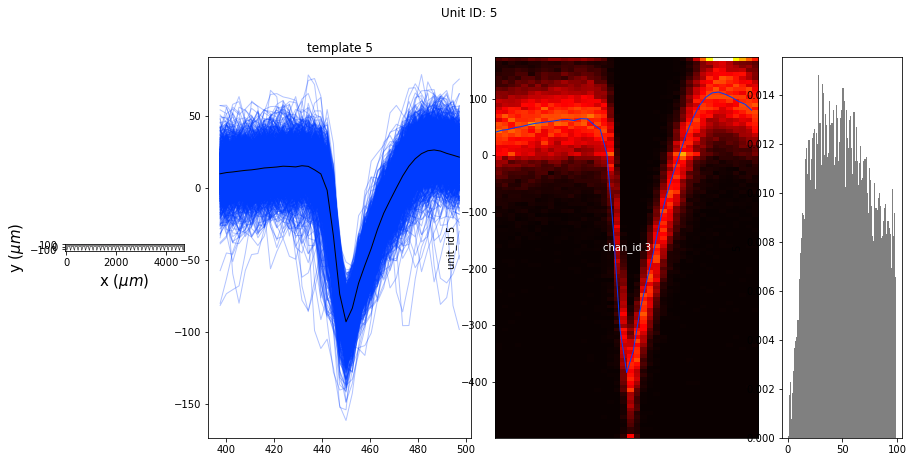

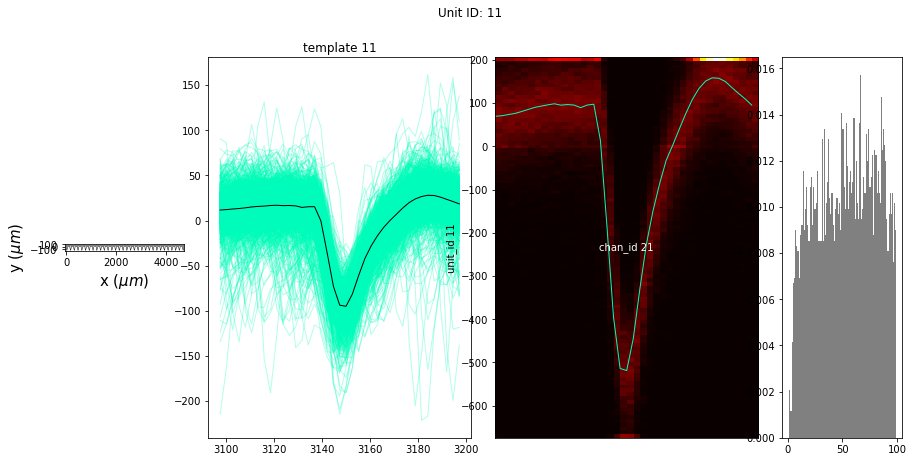

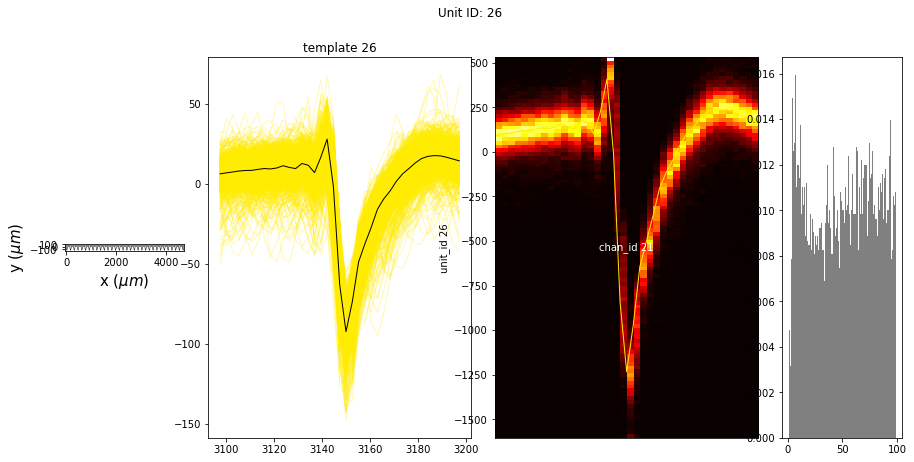

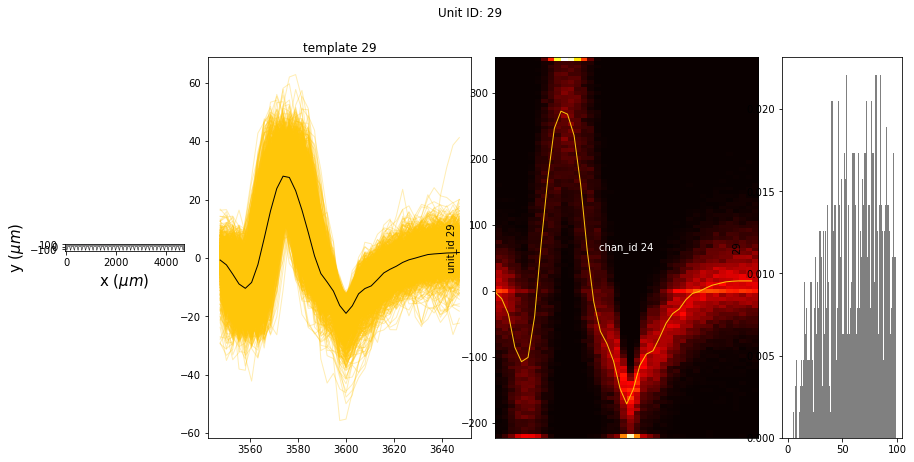

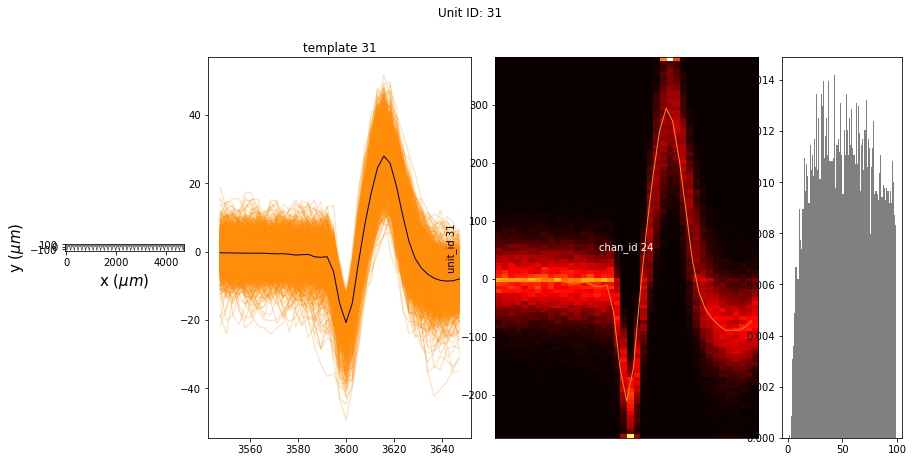

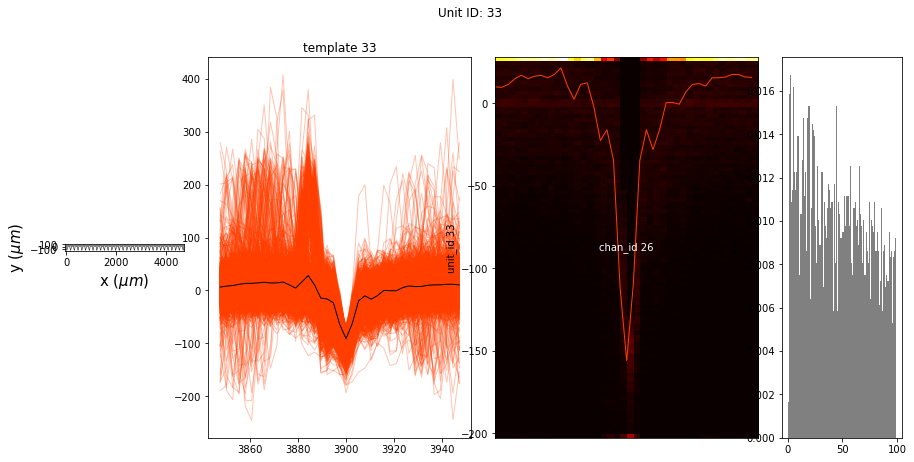

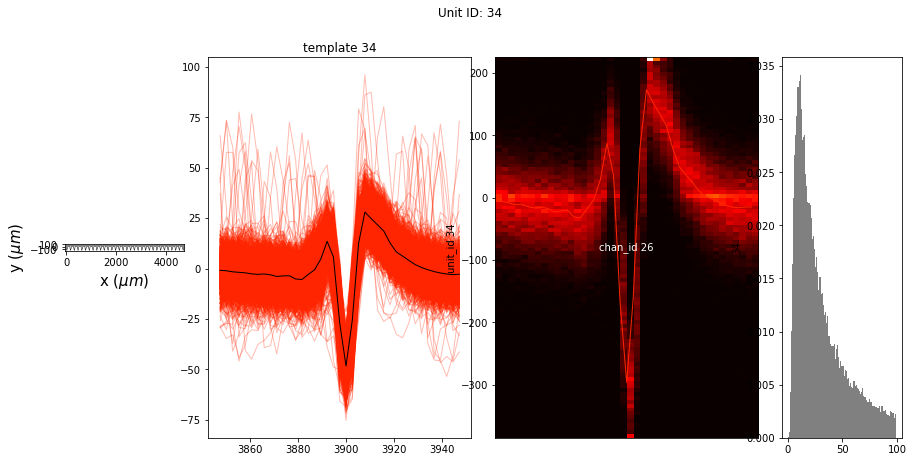

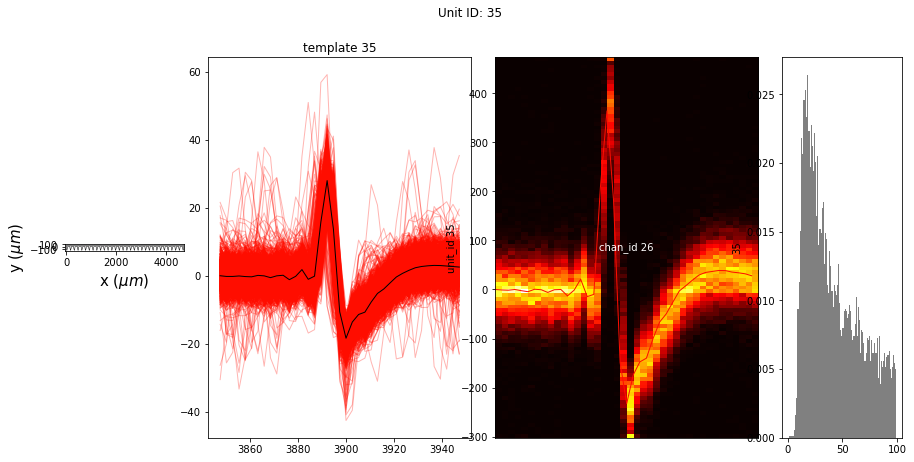

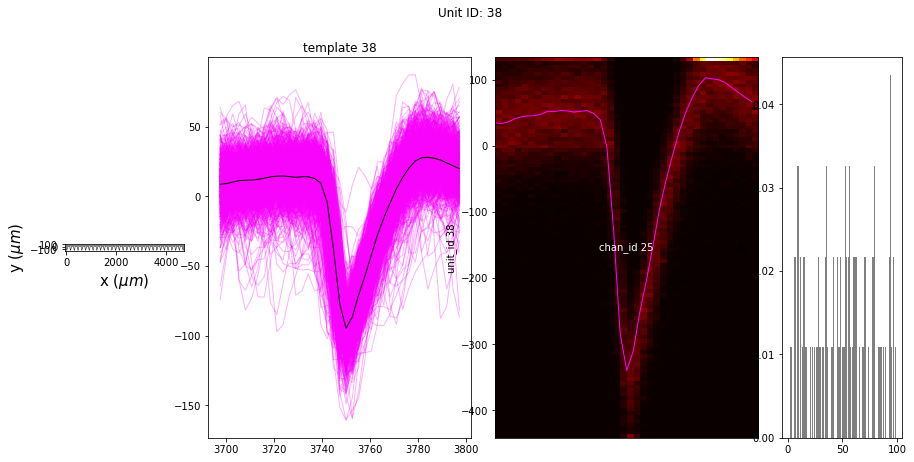

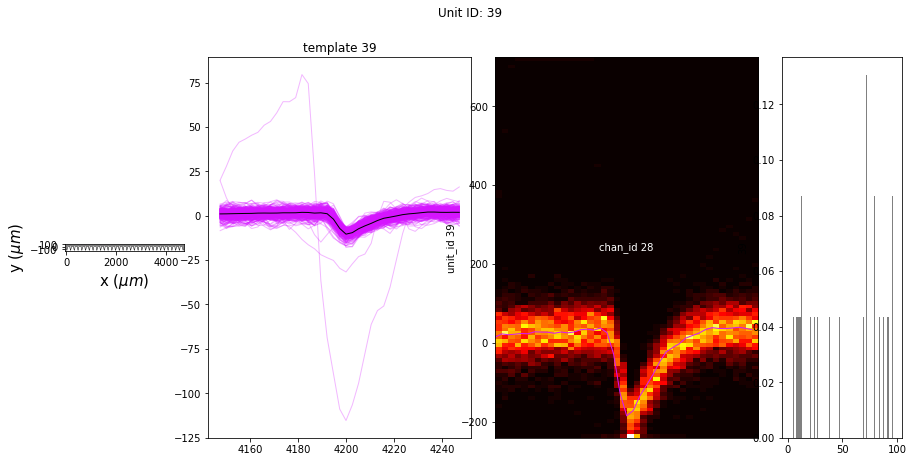

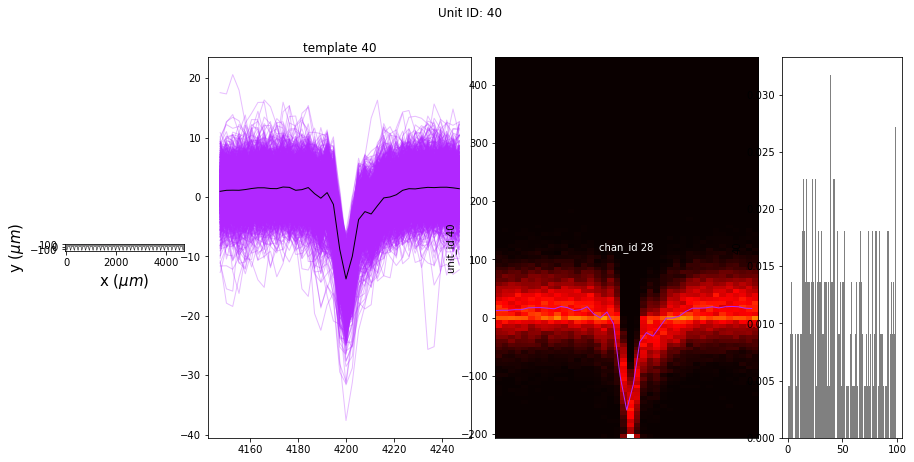

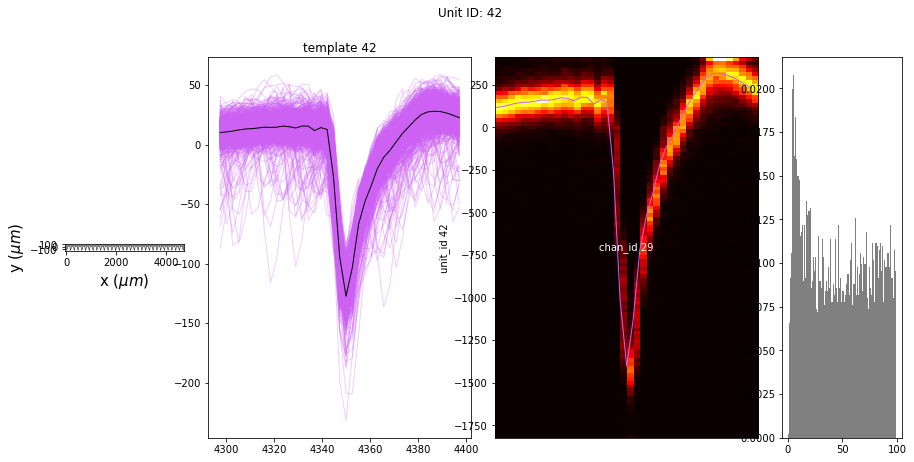

In [101]:
for index, unit in good_units.iterrows():
    w = sw.plot_unit_summary(we_mountainsort, unit_id=index)

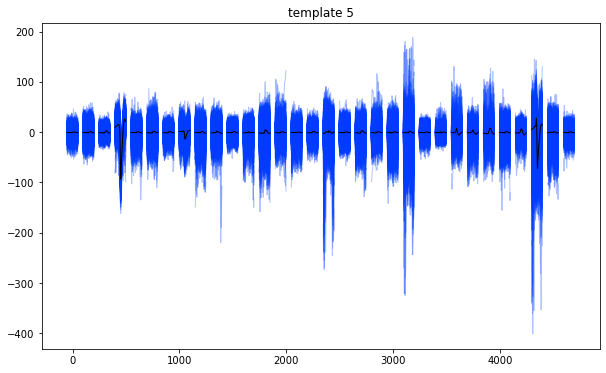

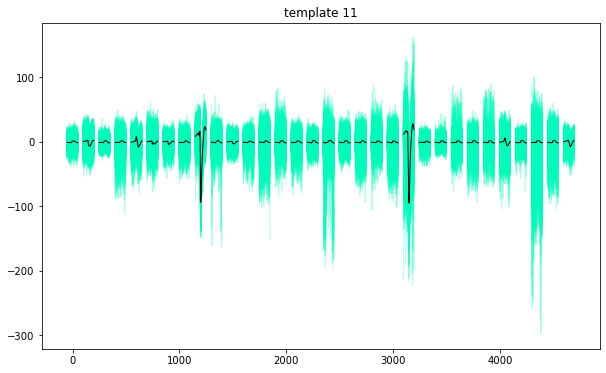

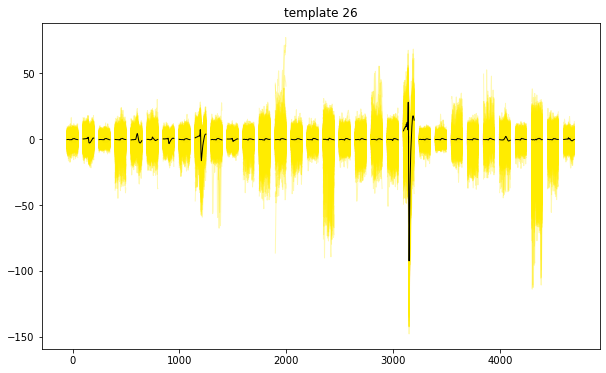

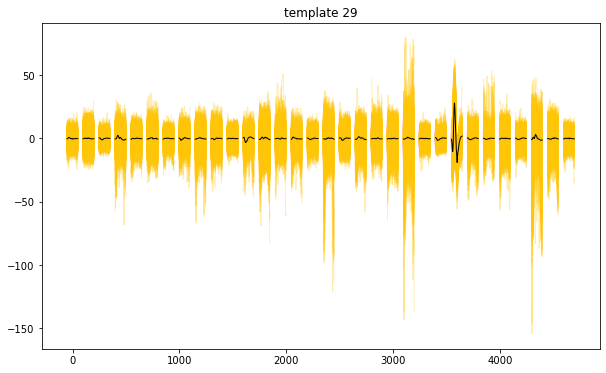

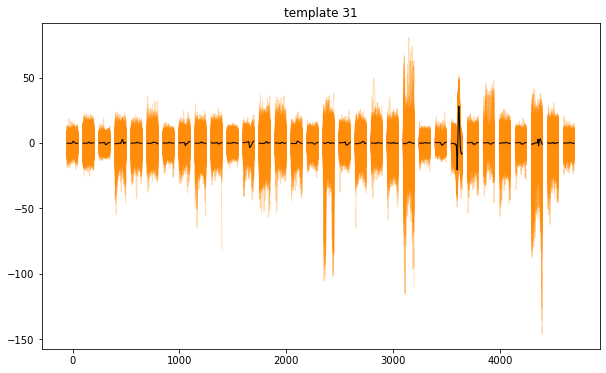

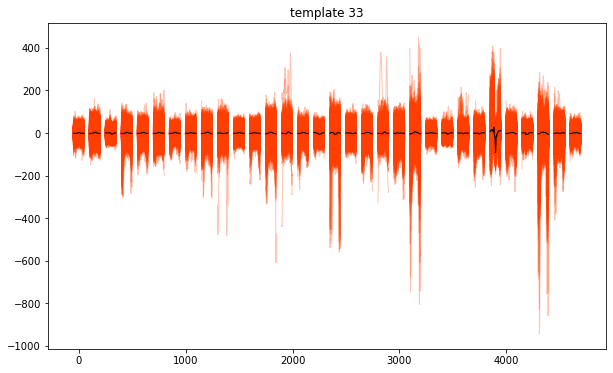

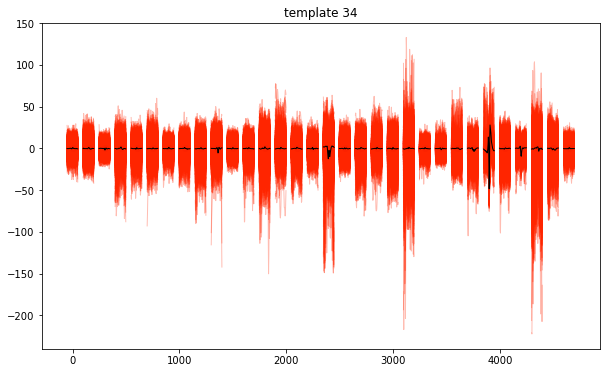

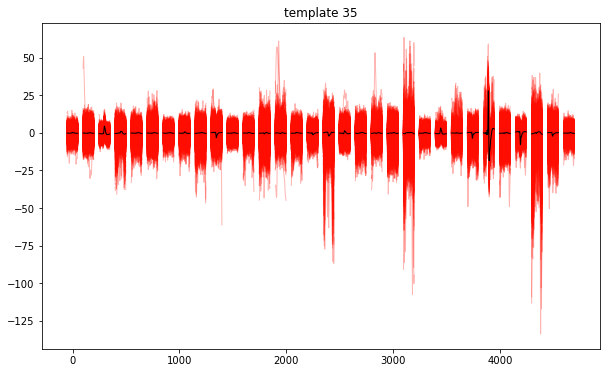

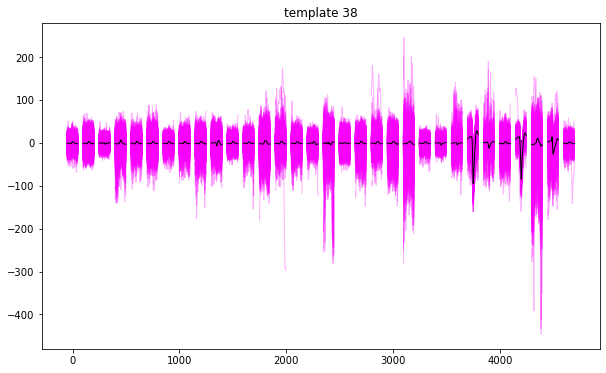

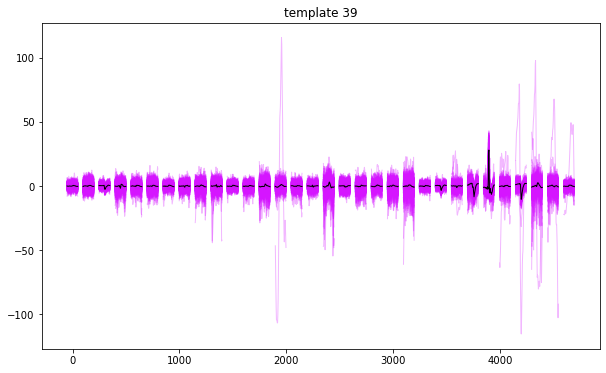

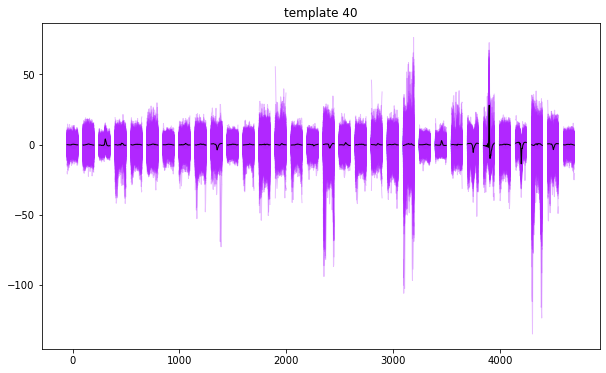

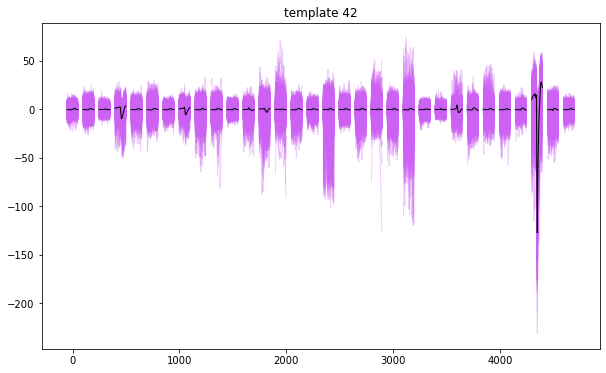

In [106]:
for index, unit in good_units.iterrows():
    sw.plot_unit_waveforms(we_mountainsort, unit_ids=[index], plot_templates=True, plot_channels=True)

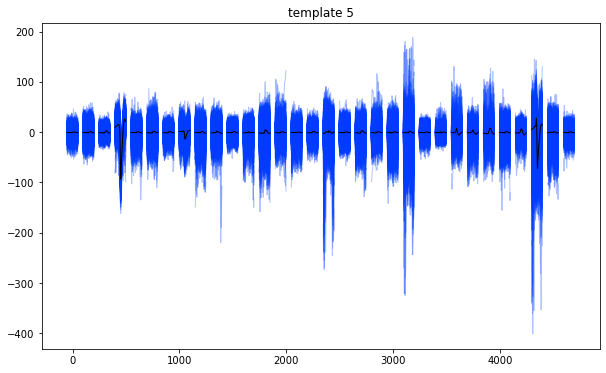

In [111]:
for index, unit in good_units[:1].iterrows():
    sw.plot_unit_waveforms(we_mountainsort, channel_ids=recording_cmr.channel_ids, unit_ids=[index], plot_templates=True, plot_channels=True)

In [110]:
recording_cmr.channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

In [115]:
st.get_channel_distances(recording_cmr).shape

(32, 32)

In [125]:
channel_to_multiple_units

{'13': [3, 16, 28, 46],
 '29': [5, 41, 42, 43, 44],
 '21': [11, 25, 26],
 '16': [19, 20],
 '24': [29, 30, 31],
 '25': [32, 38],
 '26': [33, 34, 35, 39, 40]}

(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
13
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
29
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
21
(2000, 3, 32)
(2000, 3, 32)
16
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
24
(2000, 3, 32)
(1130, 3, 32)
25
(2000, 3, 32)
(2000, 3, 32)
(2000, 3, 32)
(316, 3, 32)
(2000, 3, 32)
26


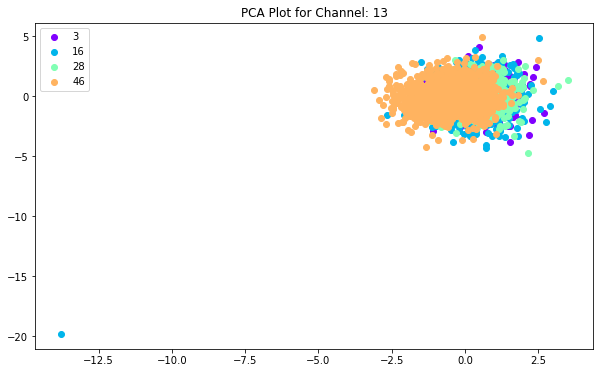

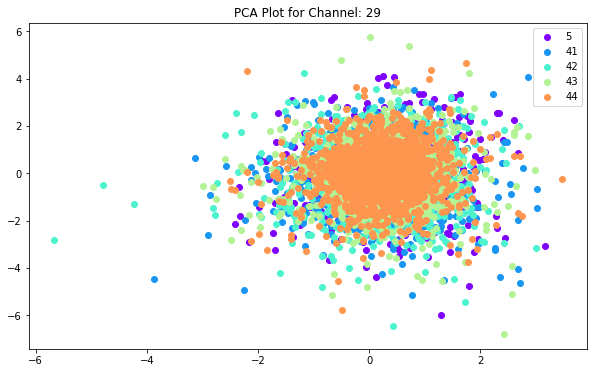

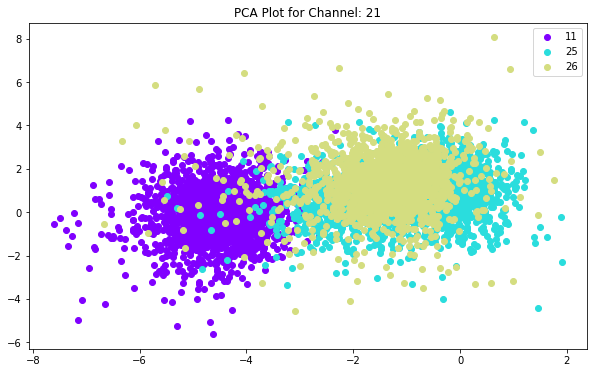

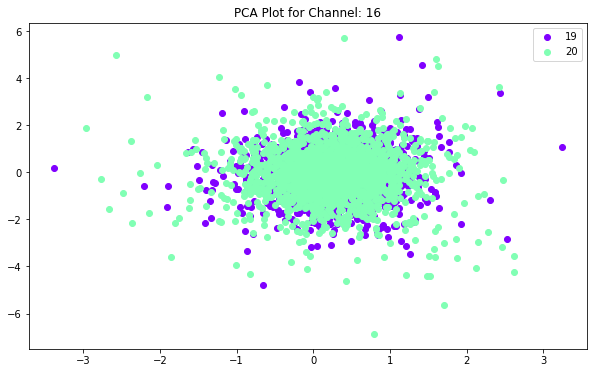

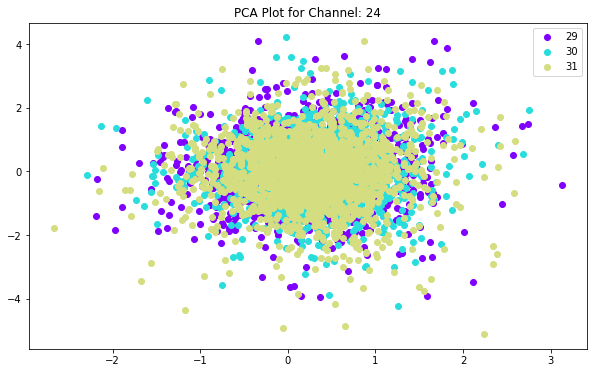

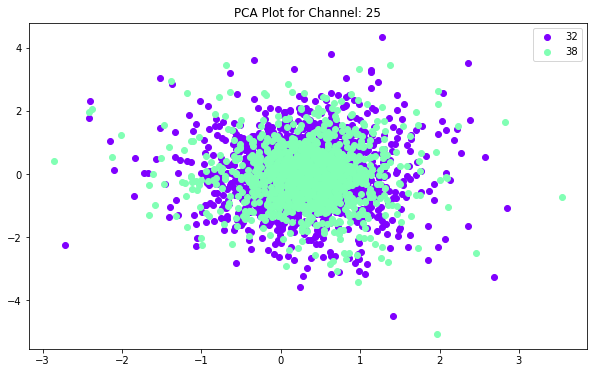

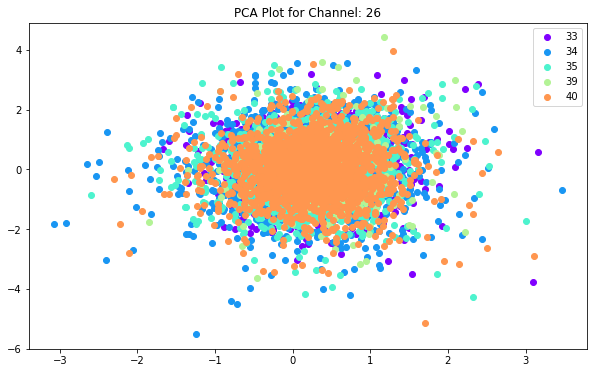

In [134]:
for channel, multiple_units in channel_to_multiple_units.items():

    n = len(multiple_units) + 1
    colors = iter(cm.rainbow(np.linspace(0, 1, n)))

    fig, ax = plt.subplots()
    for i, unit_id in enumerate(multiple_units):
        comp = pc.get_components(unit_id)
        print(comp.shape)
        color = next(colors)
        ax.scatter(comp[:, 0, 8], comp[:, 1, 8], color=color, label=unit_id)
    ax.legend()
    print(channel)
    ax.set_title("PCA Plot for Channel: {}".format(str(channel)))